Question 1:

In [207]:
#store data in a dict
employee ={1:{'Name':'John','id':1,'Salary':300,'manager_id':3},2:{'Name':'Mike','id':2,'Salary':200,'manager_id':3},3:{'Name':'Sally','id':3,'Salary':550,'manager_id':4},4:{'Name':'Jane','id':4,'Salary':500,'manager_id':7},5:{'Name':'Joe','id':5,'Salary':600,'manager_id':7},6:{'Name':'Dan','id':6,'Salary':600,'manager_id':3},7:{'Name':'Phil','id':7,'Salary':500,'manager_id':None}}

In [15]:
salary_greater=[]

In [30]:
for value in employee.values():
    if value['manager_id']!=None:
        if value['Salary']>employee[value['manager_id']]['Salary']:
            salary_greater.append(value['Name'])

In [42]:
print ('Employees whose salaries are greater than their immediate manager\'s:')
for element in salary_greater:
    print (element)

Employees whose salaries are greater than their immediate manager's:
Sally
Joe
Dan


In [32]:
full_id=set()
manager_id=set()

In [33]:
for value in employee.values():
    full_id.add(value['id'])
    manager_id.add(value['manager_id'])

In [34]:
non_manager_id = full_id.difference(manager_id)

In [53]:
non_manager_salary=[]
print ('Employees who do not manage anyone:')
for value in non_manager_id:
    print (employee[value]['Name'])
    non_manager_salary.append(employee[value]['Salary'])
print ('Their average salary is '+str(sum(non_manager_salary)/len(non_manager_salary)))

Employees who do not manage anyone:
John
Mike
Joe
Dan
Their average salary is 425.0


Question 2:

Ans: It is hard to wirte a function to check whether a variable is defined in Python, since if it is not defined, passing it to a funtion will cause an error. The following code may check whether a function is defined without using function.

In [65]:
try:
    v
except NameError:
    print("It wasn't defined.")
else:
    print("It was defined.")

Question 3:

In [73]:
from math import factorial

def combination(n, k): 
    return int((factorial(n)) / ((factorial(k)) * factorial(n - k)))

In [82]:
def pascals_triangle(rows):
    return [[combination(row, k) for k in range(row + 1)] for row in range(rows)]

In [89]:
from pprint import pprint
pprint (pascals_triangle(10))

[[1],
 [1, 1],
 [1, 2, 1],
 [1, 3, 3, 1],
 [1, 4, 6, 4, 1],
 [1, 5, 10, 10, 5, 1],
 [1, 6, 15, 20, 15, 6, 1],
 [1, 7, 21, 35, 35, 21, 7, 1],
 [1, 8, 28, 56, 70, 56, 28, 8, 1],
 [1, 9, 36, 84, 126, 126, 84, 36, 9, 1]]


Question 4:

Assume time = 1 day

First, using Historical method

In [204]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
tickers = ['AAPL','IBM', 'GOOG', 'BP','XOM','COST','GS']
weights = np.array([0.15, 0.2, 0.2, 0.15, 0.1, 0.15, 0.05])
#load data
data = pdr.get_data_yahoo(tickers, start="2016-01-01", end="2016-12-31")['Close']
#calculate returns, mean returns and cov_matrix
returns = data.pct_change()
returns = returns.dropna()
meanreturns  = returns.mean()
cov_matrix = returns.cov()
returns_portfolio = returns.dot(weights)
#At confident level of alpha =5 (Var95%)
alpha =5
Var_h=np.percentile(returns_portfolio, alpha)
print ('Historical method: Var is '+str(Var_h))

belowVaR = returns_portfolio <= Var_h
CVar_h=returns_portfolio[belowVaR].mean()
print ('Historical method: CVar is '+str(CVar_h))

Historical method: Var is -0.01416876747455724
Historical method: CVar is -0.021256080522287897


Then, using Parametric method

Assumption: the returns of the portfolio are normally distributed.  

In [206]:
from scipy.stats import norm
meanreturns_port = np.sum(meanreturns*weights)
std_port = np.sqrt( np.dot(weights.T, np.dot(cov_matrix, weights)) )
Var_p = norm.ppf(1-alpha/100)*std_port - meanreturns_port
Var_p=-1*Var_p
print ('Parametric method: Var is '+str(Var_p))

CVar_p = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*std_port - meanreturns_port
CVar_p=-1*CVar_p
print ('Parametric method: CVar is '+str(CVar_p))

Parametric method: Var is -0.014410025028747123
Parametric method: CVar is -0.01820605798416901


At last, we calculate the optimal portfolio by year end. The optimal  portfolio can be considered as one that has highest Sharpe ratio. We assume the risk-free rate to be 1% or 0.01.

First, we calculate the year returns for each stock 

In [220]:
return_year = data.resample('Y').last().pct_change().mean()

Then, we scan 100000 set of weights and calculate thier returns and volatility  

In [230]:
p_ret = [] 
p_vol = [] 
p_weights = []
num_assets = len(data.columns)
num_portfolios = 100000

In [231]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, return_year)  
                                
    p_ret.append(returns)
    sd = np.sqrt( np.dot(weights.T, np.dot(cov_matrix, weights)) ) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [232]:
result = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(data.columns.tolist()):
    result[symbol+' weight'] = [w[counter] for w in p_weights]   

In [233]:
portfolios = pd.DataFrame(result)

Then, we find out the portfolio with maximum Sharpe Ratio

In [239]:
rf = 0.01 # risk factor
optimal_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_port

Returns        0.250556
Volatility     0.188471
AAPL weight    0.051350
IBM weight     0.413977
GOOG weight    0.004441
BP weight      0.016493
XOM weight     0.014206
COST weight    0.028532
GS weight      0.471001
Name: 50156, dtype: float64

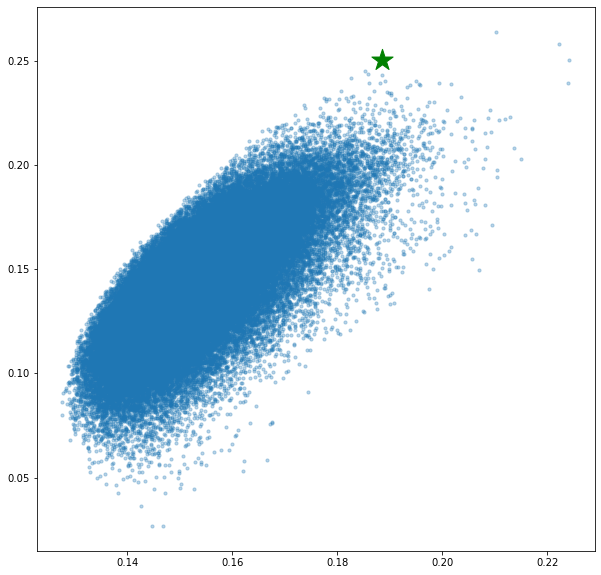

In [240]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(optimal_port[1], optimal_port[0], color='g', marker='*', s=500)

Question 5:

Access my folder my-python-project in Git Bash

a. How many python files

git ls-files "./*.ipynb" | wc -l


b. How many lines of code in total, how many lines of comment line (empty line doesn’t count)

First need to install package 'cloc' and lines of code and comment can be easily counted using 'cloc' command as below

git ls-files | xargs cloc

Please check "Capture1.jpg" in the folder

<img src="Capture1.jpg" width="500">


c. How many functions is defined in total

Can grep and count 'def ' as below

git grep -c -F 'def '


d. How many lines of changes from the current version against HEAD~3

git diff --shortstat HEAD~3

e. Total folder size (in MB) per each of the subfolder (down to 2 level depth)

du -m --max-depth=2




Question 6:

In [203]:
#use datefinder to extract dates from txt file
import datefinder
openfile = open("aa.txt", "rt")
dates_found=[]
format_found=[0,0,0,0]
for line in openfile.readlines():
    matches = datefinder.find_dates(line, source=True)
    for match in matches:
        dates_found.append(match[1])

#check whether the format of extract dates can match with one of the desired ones
for date in dates_found:
    try:
        d1 = datetime.strptime(date, '%d %b %Y')
        format_found[0]=1

    except ValueError:
            continue
            
for date in dates_found:                        
    try:
        d2 = datetime.strptime(date, '%Y/%m/%d')
        format_found[1]=1

    except ValueError:
            continue
            
for date in dates_found:            
    try:
        d3 = datetime.strptime(date, '%m/%d/%Y')
        format_found[2]=1

    except ValueError:
            continue
            
for date in dates_found:             
    try:
        d4 = datetime.strptime(date, '%d/%m/%Y')
        format_found[3]=1

    except ValueError:
            continue            
 
format_total=sum(format_found)
print ('Total date format found: '+str(format_total))
openfile.close()

Total date format found: 4
